In [69]:
from IPython.core.display import HTML
css_file = '../../../msc/custom.css' 
HTML(open(css_file, 'r').read()) 

# The Generalized Roy Model

**Roadmap**

* Data Generating Process
* Objects of Interest
* Processing Specification
* Setting up Simulation
* Conducting Estimation

Over the next couple of lectures, we will then constantly refine the basic code and explore elements of software engineering such as Object-Oriented Programming, Unit Testing, Debugging, and Profiling.

## Data Generating Process

The generalized Roy model is characterized by the following set of equations. 

**Potential Outcomes**

\begin{align}
Y_1 &= X\beta_1 + U_1 \\
Y_0 &= X\beta_0 + U_0 
\end{align}

**Cost**

\begin{align}
C = Z\gamma + V
\end{align}

**Choice**

\begin{align}
S &= Y_1 - Y_0 - C\\
D &= I[S > 0]
\end{align}

**Observed Outcome**

\begin{align}
Y = D Y_1 + (1 - D)Y_0
\end{align}


$(Y_1, Y_0)$ are objective outcomes associated with each potential treatment state $D$ and realized after the treatment decision. $Y_1$ refers to the outcome in the treated state and $Y_0$ in the untreated state. $C$ denotes the subjective cost of treatment participation. Any subjective benefits,e.g. job amenities, are included (as a negative contribution) in the subjective cost of treatment. Agents take up treatment $D$ if they expect the objective benefit to outweigh the subjective cost. In that case, their subjective evaluation, i.e. the expected surplus from participation $S$, is positive. If agents take up treatment, then the observed outcome $Y$ corresponds to the outcome in the presence of treatment $Y_1$. Otherwise, $Y_0$ is observed. The unobserved potential outcome is referred to as the counterfactual outcome. 

## Objects of Interest

**Individual-specific Treatment Effect**

\begin{align}
B = Y_1 - Y_0 = X(\beta_1 - \beta_0) + (U_1 - U_0)
\end{align}

* Heterogeneity
 * Observed
 * Unobserved
 
**Average Treatment Effect**

\begin{align}
ATE & = E\left[Y_1 - Y_0 \right]\\
TT  & = E\left[Y_1 - Y_0 \mid D = 1\right]\\
TUT & = E\left[Y_1 - Y_0 \mid D = 0\right]
\end{align}

**Distribution of Potential Outcomes**

\begin{align}
F_{Y_1,Y_0}
\end{align}

* Distribution of Benefits
 * Heterogeneity
 * Population Shares

### Additional Information

To be collected.

## Processing of Model Specification

We manage the model specification in an external text file, which is called *init.ini*.

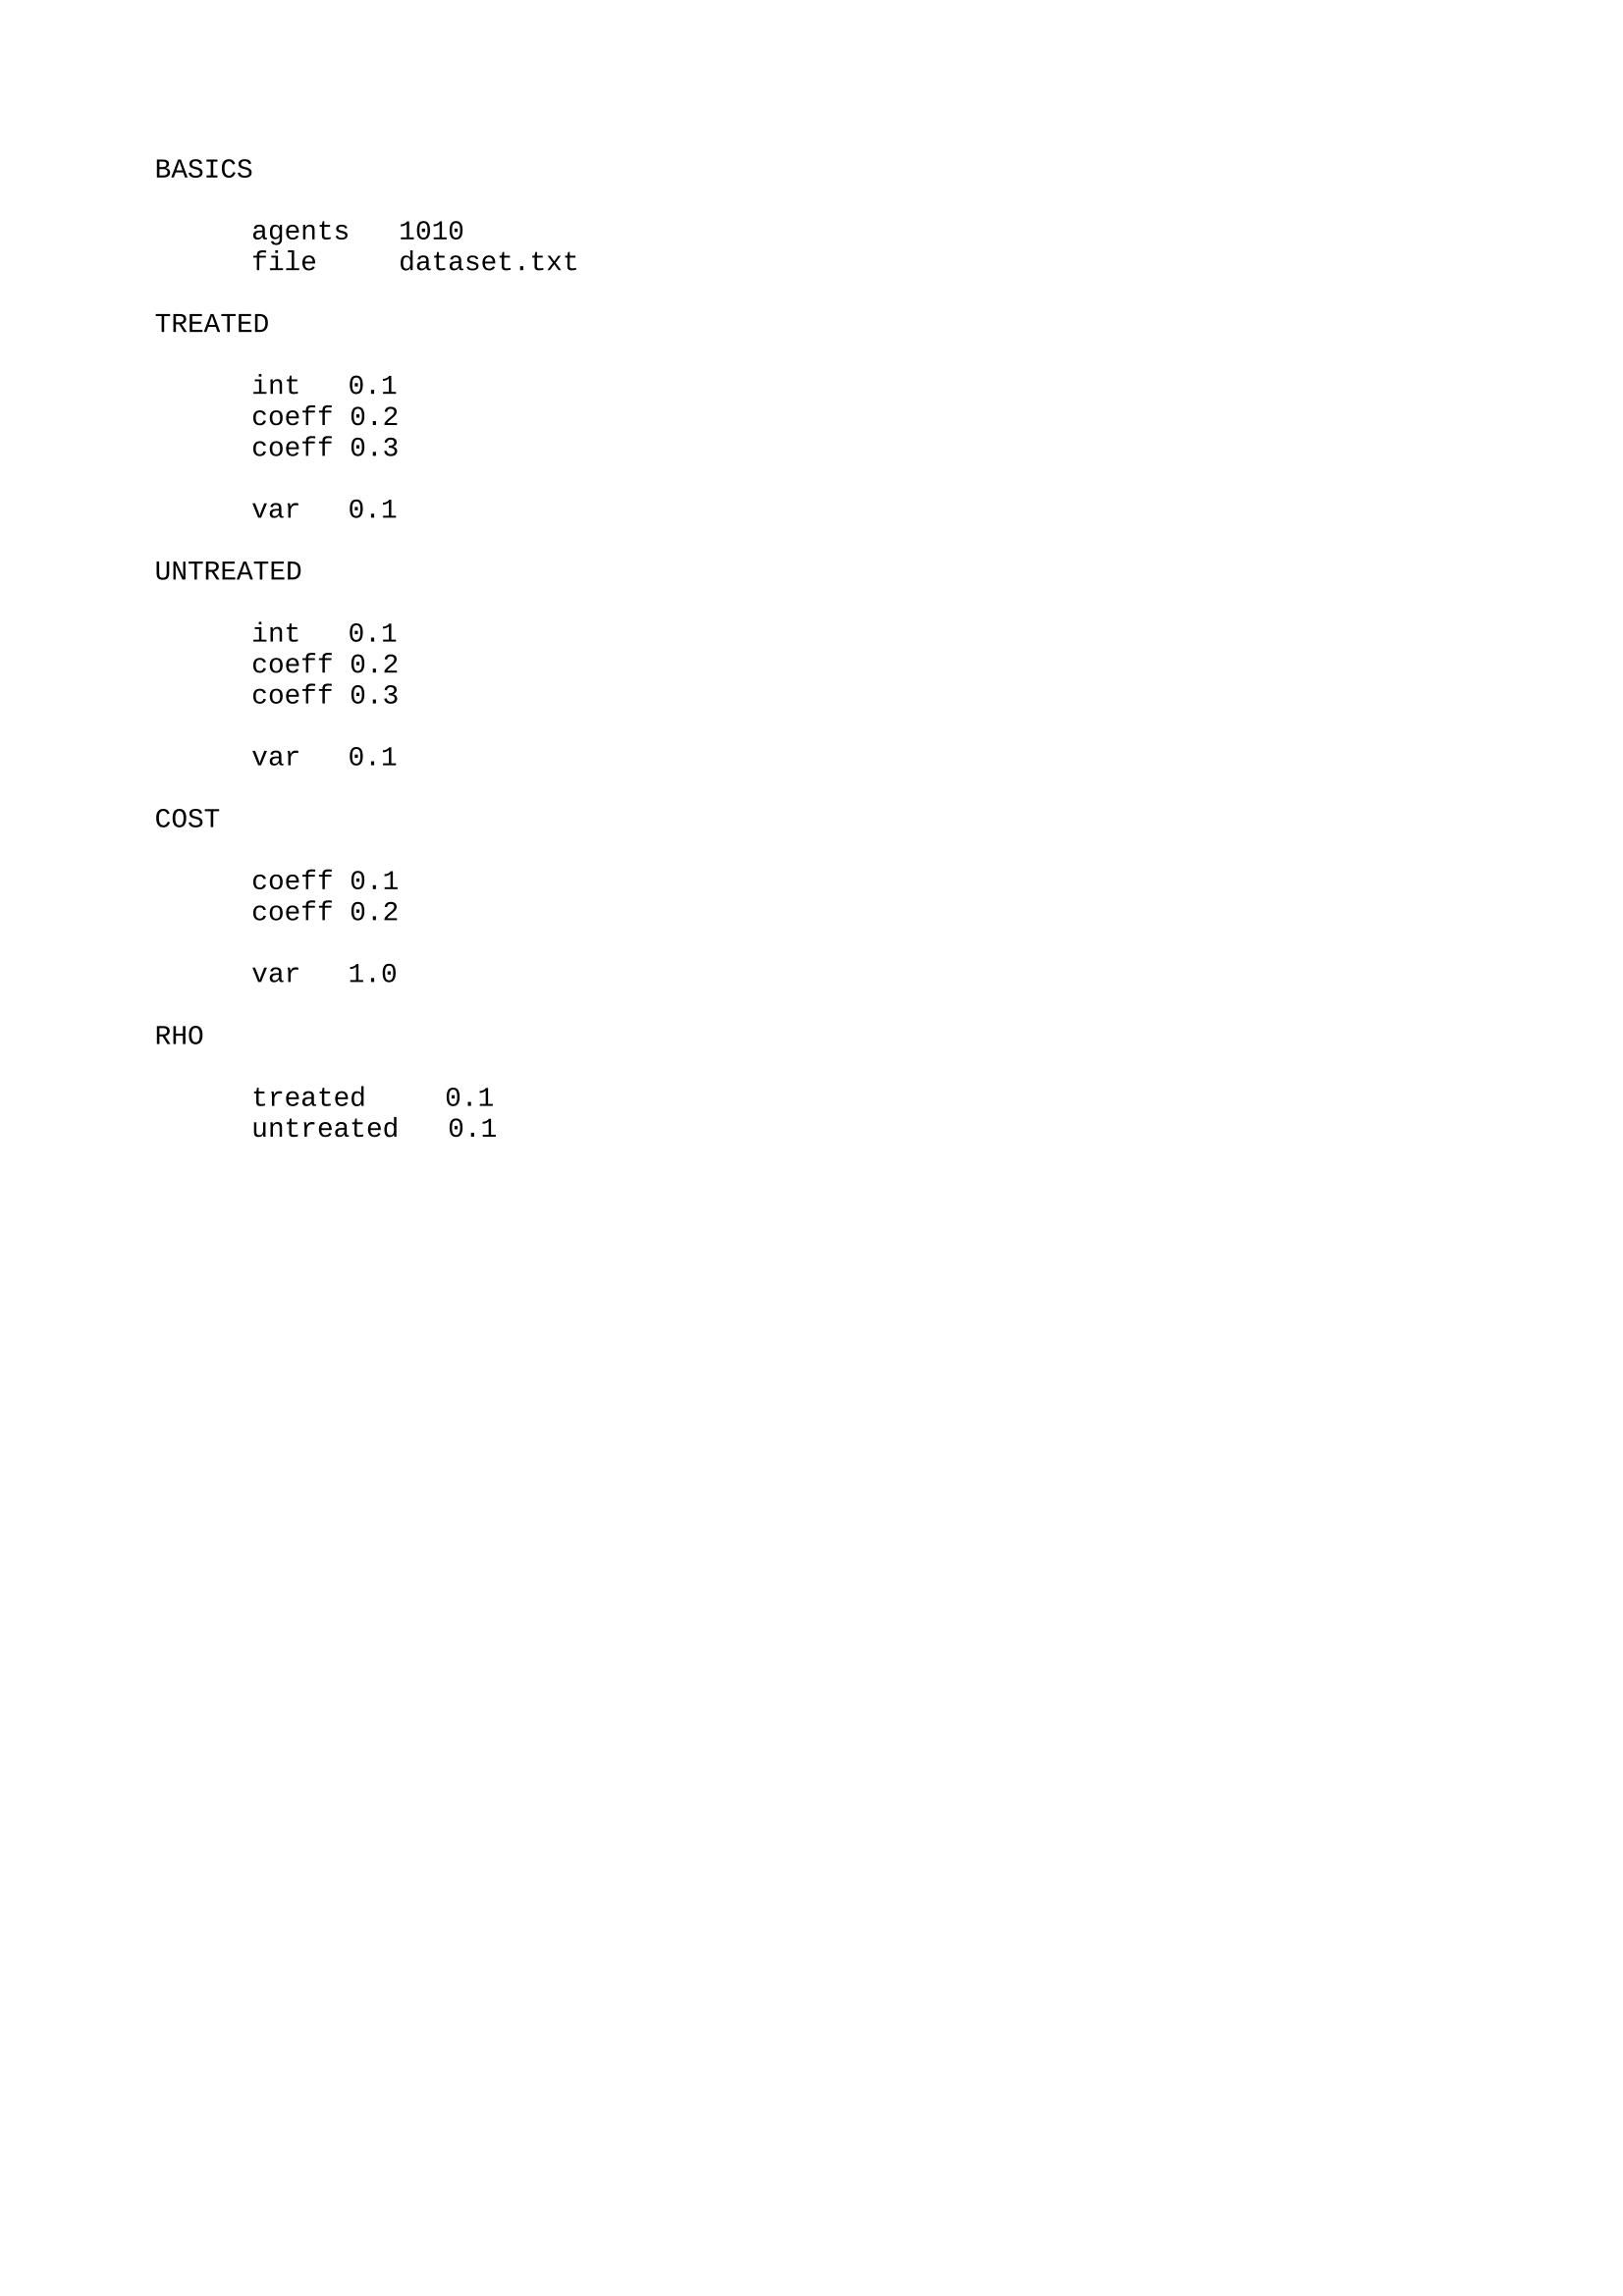

In [70]:
from IPython.display import Image
Image(filename='images/init.png')

Now we will develop a function that processes the initialization file.

In [71]:
import numpy as np

def _check_integrity(dict_):
    ''' Check integrity of initFile dict.
    '''
    # Antibugging 
    assert (isinstance(dict_, dict))
    
    # Check number of agents 
    assert (dict_['BASICS']['agents'] > 0)
    assert (isinstance(dict_['BASICS']['agents'], int))
    
    # Finishing 
    return True

def _add_auxiliary(dict_):
    ''' Add some auxiliary objects.
    '''
    # Antibugging 
    assert (isinstance(dict_, dict))
    
    # Initialize container
    dict_['AUX'] = {}
    
    # Full set of coefficients.
    dict_['TREATED']['all']  = [dict_['TREATED']['int']]
    dict_['TREATED']['all'] += dict_['TREATED']['coeff']
    dict_['TREATED']['all']  = np.array(dict_['TREATED']['all'])

    dict_['UNTREATED']['all']  = [dict_['UNTREATED']['int']]
    dict_['UNTREATED']['all'] += dict_['UNTREATED']['coeff']
    dict_['UNTREATED']['all']  = np.array(dict_['UNTREATED']['all'])
    
    dict_['COST']['all'] = np.array(dict_['COST']['coeff'])
    
    # Number of covariates
    num_covars_out = len(dict_['TREATED']['coeff']) + 1
    num_covars_cost = len(dict_['COST']['coeff']) 

    dict_['AUX']['num_covars_out']  = num_covars_out
    dict_['AUX']['num_covars_cost'] = num_covars_cost
    
    # Number of covariates
    dict_['AUX']['num_paras'] = 2*num_covars_out + num_covars_cost + 2 + 2
    
    # Finishing
    return dict_

def _process_cases(list_):
    """ Process cases and determine whether keyword or empty 
        line.
    """
    # Antibugging
    assert (isinstance(list_, list))

    # Initialize containers 
    is_empty, is_keyword = None, None
    
    # Get information 
    is_empty = (len(list_) == 0)
    
    if not is_empty:
        is_keyword = list_[0].isupper()
    else:
        is_keyword = False
        
    # Antibugging 
    assert (is_keyword in [True, False])
    assert (is_empty in [True, False])
    
    # Finishing 
    return is_empty, is_keyword

In [72]:
import shlex

def read_init():
    ''' This function reads the init.ini file.
    '''
    # Initialization
    dict_ = {}
    
    for line in open('init.ini').readlines():
    
        list_ = shlex.split(line)
           
        # Determine special cases
        is_empty, is_keyword = _process_cases(list_)
                    
        # Applicability
        if is_empty:
            continue
                
        if is_keyword:
            keyword = list_[0]
            dict_[keyword] = {}
            continue
        
        # Distribute information
        name, val = list_[0], list_[1]
        
        # Prepare container.
        if name not in dict_[keyword].keys():
            dict_[keyword][name] = None

            if name in ['coeff']:
                dict_[keyword][name] = []
        
        # Type conversion
        if name in  ['agents']:
            val = int(val)
        elif name in ['file']:
            val = str(val)
        else:
            val = float(val)
        
        # Collect information
        if name in ['coeff']:
            dict_[keyword][name] += [val]
        else:
            dict_[keyword][name] = val

    # Add auxiliary objects
    dict_ = _add_auxiliary(dict_)
                
    # Check quality.
    _check_integrity(dict_)
    
    # Finishing.
    return dict_


Let us check if it is all working.

# Setting up the Simulation

**Distributinal Assumptions**

*Observables*
\begin{align}
X & \sim \mathbb{N}(0, 1) \\
Z & \sim \mathbb{N}(0, 1) \\
\end{align}

*Unobservables*  
\begin{align}
U_1 & \sim \mathbb{N}(0, \sigma_{U_1}) \\
U_0 & \sim \mathbb{N}(0, \sigma_{U_0}) \\
V   & \sim \mathbb{N}(0, \sigma_{V})
\end{align}



In [73]:
init_dict = read_init()

In [74]:
import numpy as np

def check_integrity(Y1, Y0, Y, D):
    ''' Check quality of simulated sample. 
    '''
    assert (np.all(np.isfinite(Y1)))
    assert (np.all(np.isfinite(Y0)))

    assert (np.all(np.isfinite(Y)))
    assert (np.all(np.isfinite(D)))

    assert (Y1.dtype == 'float')
    assert (Y0.dtype == 'float')

    assert (Y.dtype == 'float')
    assert (D.dtype == 'float')

    assert ((D.all() in [1.0, 0.0]))
    
def write_out(Y, D, X, Z, file_name):
    ''' Write out simulated data to file.
    '''
    
    np.savetxt(file_name, np.column_stack((Y, D, X, Z)), fmt= '%8.3f')


In [75]:
np.random.seed(123)

import os

def simulate_model():
    ''' Simulate a model based on the initialization file.
    '''
    
    # Antibugging
    assert (os.path.exists('init.ini'))
    
    # Read specification
    init_dict = read_init()
    
    # Distribute information
    num_agents = init_dict['BASICS']['agents']
    file_name  = init_dict['BASICS']['file']

    Y1_coeffs  = init_dict['TREATED']['all']
    Y0_coeffs  = init_dict['UNTREATED']['all']
    
    C_coeffs   = np.array(init_dict['COST']['coeff'])

    U1_var     = init_dict['TREATED']['var'] 
    U0_var     = init_dict['UNTREATED']['var']  

    V_var      = init_dict['COST']['var']

    U1V_rho    = init_dict['RHO']['treated']  
    U0V_rho    = init_dict['RHO']['untreated']
    
    # Auxiliary objects
    U1V_cov    = U1V_rho*np.sqrt(U1_var)*np.sqrt(V_var)
    U0V_cov    = U0V_rho*np.sqrt(U0_var)*np.sqrt(V_var)

    num_covars_out  = Y1_coeffs.shape[0]
    num_covars_cost = C_coeffs.shape[0]

    # Simulate observables
    means  = np.tile(0.0, num_covars_out)
    covs   = np.identity(num_covars_out)

    X      = np.random.multivariate_normal(means, covs, num_agents)
    X[:,0] = 1.0

    means  = np.tile(0.0, num_covars_cost)
    covs   = np.identity(num_covars_cost)

    Z      = np.random.multivariate_normal(means, covs, num_agents)
    
    # Construct index of observable characteristics
    Y1_level = np.dot(Y1_coeffs, X.T)
    Y0_level = np.dot(Y0_coeffs, X.T)
    C_level  = np.dot(C_coeffs, Z.T)
    
    # Simulate unobservables
    means = np.tile(0.0, 3)
    vars_ = [U1_var, U0_var, V_var]
    covs  = np.diag(vars_)

    covs[0,2] = U1V_cov 
    covs[2,0] = covs[0,2]

    covs[1,2] = U0V_cov
    covs[2,1] = covs[1,2]

    U = np.random.multivariate_normal(means, covs, num_agents)
    
    # Simulate endogenous variables
    Y1 = np.tile(np.nan, (num_agents))
    Y0 = np.tile(np.nan, (num_agents))
    Y  = np.tile(np.nan, (num_agents))

    D  = np.tile(np.nan, (num_agents))

    for i in range(num_agents):

        # Distribute unobservables.
        U1, U0, V = U[i,0], U[i,1], U[i,2]

        # Decision Rule.
        expectedBenefits = Y1_level[i] - Y0_level[i]
        cost             = C_level[i]  + V 

        D[i] = np.float((expectedBenefits - cost > 0))

        # Potential outcomes.
        Y1[i] = Y1_level[i] + U1
        Y0[i] = Y0_level[i] + U0

        # Observed outcomes.
        Y[i]  = D[i]*Y1[i] + (1.0 - D[i])*Y0[i]
    
    # Save to disk
    write_out(Y, D, X, Z, file_name)
    
    # Return selected features of data
    return Y1, Y0, D

Let us check if it is all working.

In [76]:
Y1, Y0, D = simulate_model()

Given our parametrization, let us revisit our objects of interest. We start with the individual-specific benefits. Please note the use of the [StatsModels](http://statsmodels.sourceforge.net/devel/index.html) library,
that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. Think of it as a replacement for using [R](http://www.r-project.org/). 

Populating the interactive namespace from numpy and matplotlib

Average Treatment Effects

     ATE        0.39

     TT         0.41

     TUT        0.27



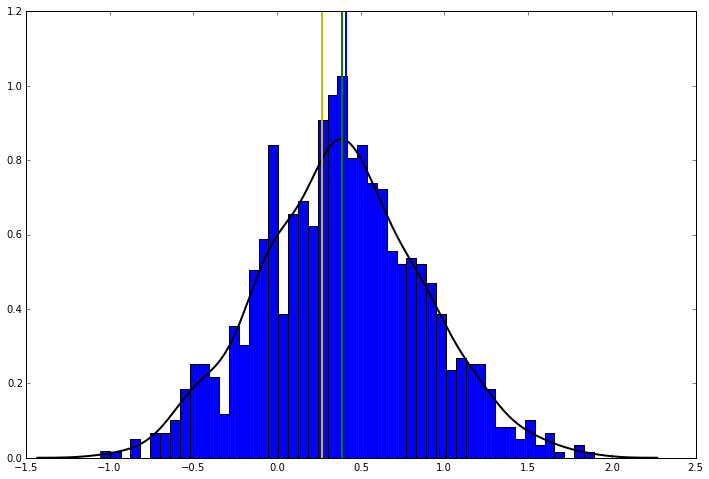

In [92]:
# import of libraries
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%pylab inline

# Auxiliary variables
B = Y1 - Y0

# Create histogram and density estimate of benefits.
kde = sm.nonparametric.KDEUnivariate(B)
kde.fit()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(B, bins=50, normed=True, color='blue')
ax.plot(kde.support, kde.density, lw=2, color='black')

# Calcuate the average treatment effects
ate, tt, tut = np.mean(B), np.mean(B[D==1]), np.mean(B[D==0])

# Pretty formatting of strings and output
fmt = '     {0:<5}{1:10.2f}\n'

print '\nAverage Treatment Effects\n'
print fmt.format('ATE ', ate)
print fmt.format('TT', tt)
print fmt.format('TUT ', tut)

# Let us add them to our plot.
plt.axvline(x=ate, ymin=0, ymax=5, linewidth=2, color='g')
plt.axvline(x=tt, ymin=0, ymax=5, linewidth=2, color='b')
plt.axvline(x=tut, ymin=0, ymax=5, linewidth=2, color='y')


## Estimation

Now, we will perform Maximum Likelihood Estimation using alternative optimization algorithms. Here is the likelihood function:

\begin{align}
\mathcal{L}(\theta; X, Z) =\sum^N_{i=1} D\mathcal{L_1} + (1 - D)\mathcal{L_1},
\end{align}
where
\begin{align}
\mathcal{L_1} = & \log\left(\frac{1}{\sigma_{U_1}}\phi\left(\frac{Y_i - X_i\beta}{\sigma_{U_1}}\right)\Phi\left(\frac{Z_i\gamma - \rho_{U_1,V}(Y_i - X_i\beta)/\sigma_{U_1}}{\sqrt{1 - \rho_{U_1,V}}}\right)\right) \\
\mathcal{L_0} =  &\log\left(\frac{1}{\sigma_{U_0}}\phi\left(\frac{Y_i - X_i\beta}{\sigma_{U_0}}\right)\Phi\left(\frac{Z_i\gamma - \rho_{U_0,V}(Y_i - X_i\beta)/\sigma_{U_0}}{\sqrt{1 - \rho_{U_0,V}}}\right)\right)
\end{align}

In [ ]:
from scipy.stats    import norm

def _distribute_parameters(x, num_covars_out):
    ''' Distribute the parameters.
    '''       
    # Antibugging
    assert (isinstance(x, np.ndarray))
    assert (isinstance(num_covars_out, int))
    assert (num_covars_out > 0)
    
    # Initialize containers
    rslt = {}

    # Distribute parameters
    rslt['Y1_coeffs'] = x[:num_covars_out]
    rslt['Y0_coeffs'] = x[num_covars_out:(2*num_covars_out)]
    
    rslt['C_coeffs'] = x[(2*num_covars_out):(-4)]
    
    rslt['U1_var']  = np.exp(x[(-4)])
    rslt['U0_var']  = np.exp(x[(-3)])

    rslt['U1V_rho'] = -1.0 + 2.0/(1.0 + np.exp(-x[-2]))    
    rslt['U0V_rho'] = -1.0 + 2.0/(1.0 + np.exp(-x[-1])) 

    # Finishing.
    return rslt

def negative_log_likelihood(args, Y, D, X, Z):
    ''' Negative Log-likelihood function of the Generalized Roy Model.
    '''   
    # Distribute parametrization
    Y1_coeffs   = np.array(args['Y1_coeffs'])
    Y0_coeffs   = np.array(args['Y0_coeffs'])
    
    C_coeffs    = np.array(args['C_coeffs'])
    
    U1_var    = args['U1_var'] 
    U0_var    = args['U0_var'] 
    
    U1V_rho   = args['U1V_rho']
    U0V_rho   = args['U0V_rho']

    # Auxiliary objects.
    num_agents   = Y.shape[0]
    choiceCoeffs = np.concatenate((Y1_coeffs - Y0_coeffs, - C_coeffs))
    
    # Likelihood construction.
    likl = 0.00
        
    for i in range(num_agents):
            
        G   = np.concatenate((X[i,:], Z[i,:]))
        idx = np.dot(choiceCoeffs, G)       

        if(D[i] == 1.00):
                    
            coeffs = Y1_coeffs
            rho = U1V_rho
            sd  = np.sqrt(U1_var) 
                
        else:
                            
            coeffs = Y0_coeffs
            rho = U0V_rho
            sd  = np.sqrt(U0_var) 
        
        arg_one   = (Y[i] - np.dot(coeffs, X[i,:]))/sd     
        arg_two   = (idx - rho*arg_one)/np.sqrt(1.0 - rho**2)
        
        cdf_evals = norm.cdf(arg_two)
        pdf_evals = norm.pdf(arg_one) 

        if(D[i] == 1.0):
                
            contrib = (1.0/sd)*pdf_evals*cdf_evals
            
        else:
                
            contrib = (1.0/sd)*pdf_evals*(1.0 - cdf_evals)

        contrib  = np.clip(contrib, 1e-20, 1.0)
            
        likl    += -np.log(contrib)
            
    likl = (1.0/float(num_agents))*likl
    
    # Quality checks.
    assert (isinstance(likl, float))
    assert (np.isfinite(likl))
    
    # Finishing.
    return likl

def load_data():
    ''' Load dataset.
    '''
    init_dict = read_init()
    
    # Auxiliary objects
    num_covars_out  = init_dict['AUX']['num_covars_out']
    num_covars_cost = init_dict['AUX']['num_covars_cost']
    
    # Read dataset
    data = np.genfromtxt(init_dict['BASICS']['file'])

    # Distribute data
    Y, D = data[:,0], data[:,1]

    X, Z = data[:,2:(num_covars_out + 2)], data[:,-num_covars_cost:]

    # Finishing
    return Y, D, X, Z

def max_interface(x, Y, D, X, Z):
    ''' Interface to the SciPy maximization routines.
    '''
    # Auxiliary objects.
    num_covars_out = X.shape[1]
    
    # Collect maximization arguments.
    rslt = _distribute_parameters(x, num_covars_out)
    
    # Calculate likelihood.
    likl = negative_log_likelihood(rslt, Y, D, X, Z)
        
    # Finishing.
    return likl

Let us evaluate the criterion function.

In [ ]:
# Load model information
init_dict  = read_init() 

Y, D, X, Z = load_data()

'Set up the parametrization. '
args = {}

args['Y1_coeffs'] = np.array(init_dict['TREATED']['all'])
args['Y0_coeffs'] = np.array(init_dict['UNTREATED']['all'])

args['C_coeffs'] = np.array(init_dict['COST']['all'])

args['U1_var']  = init_dict['TREATED']['var']
args['U0_var']  = init_dict['UNTREATED']['var']

args['U1V_rho'] = init_dict['RHO']['treated']
args['U0V_rho'] = init_dict['RHO']['untreated']

likl = negative_log_likelihood(args, Y, D, X, Z)

Let us now run the estimation.

In [ ]:
from scipy.optimize import minimize

# Load model information
init_dict = read_init()

Y, D, X, Z = load_data()

# Create auxiliary objects
num_paras = init_dict['AUX']['num_paras']

x0 = np.zeros(num_paras)

# Call alternative optimizers
opts = {}

opts['maxiter'] = 100

for optimizer in ['BFGS', 'Nelder-Mead']:
    
    rslt = minimize(max_interface, x0, args=(Y, D, X, Z), 
                    method=optimizer, options=opts)
    
    # Tranformation to internal parameters
    num_covars_out = init_dict['AUX']['num_covars_out']

    parameters = _distribute_parameters(rslt['x'], num_covars_out) 

    print '\n Optimizer ', optimizer
    print parameters

## Cleanup

In [ ]:
try:
    
    os.remove('dataset.txt')
    
except OSError:
    
    pass